In [32]:
# Imports
import matplotlib.pyplot as plt
import numpy as np

# Global Parameters (NN architecture)

Lx = 100 # Inputs
Lh = 1000 # Hidden layer Neurons
Ly = 10 # Outputs

def relu(x):
  return np.maximum(0,x)

def step(x):
  return np.heaviside(x, np.zeros(x.shape))


## Stochastic Gradient Descent (torch)

In [8]:
import torch
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

In [11]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution

        self.fc1 = nn.Linear(Lx, Lh)  # 5*5 from image dimension
        self.fc2 = nn.Linear(Lh, Ly)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net = Net()


In [25]:
wh_son = torch.normal(torch.zeros(Lh,Lx), torch.ones(Lh,Lx))
wh_dad = torch.normal(torch.zeros(Lh,Lx), torch.ones(Lh,Lx))

wy_son = torch.normal(torch.zeros(Ly,Lh), torch.ones(Ly,Lh))
wy_dad = torch.normal(torch.zeros(Ly,Lh), torch.ones(Ly,Lh))


## The idea is we want the son to converge to the dad.

x = torch.normal(torch.zeros(1000, Lx), torch.ones(1000, Lx))

target = (wy_dad @ F.relu(wh_dad @ x.T)).T

optimizer = optim.SGD(net.parameters(), lr=0.001)
epochs = torch.arange(300)
criterion = nn.MSELoss()



Text(0.5, 1.0, 'Online Gradient Descent; Epochs vs Error')

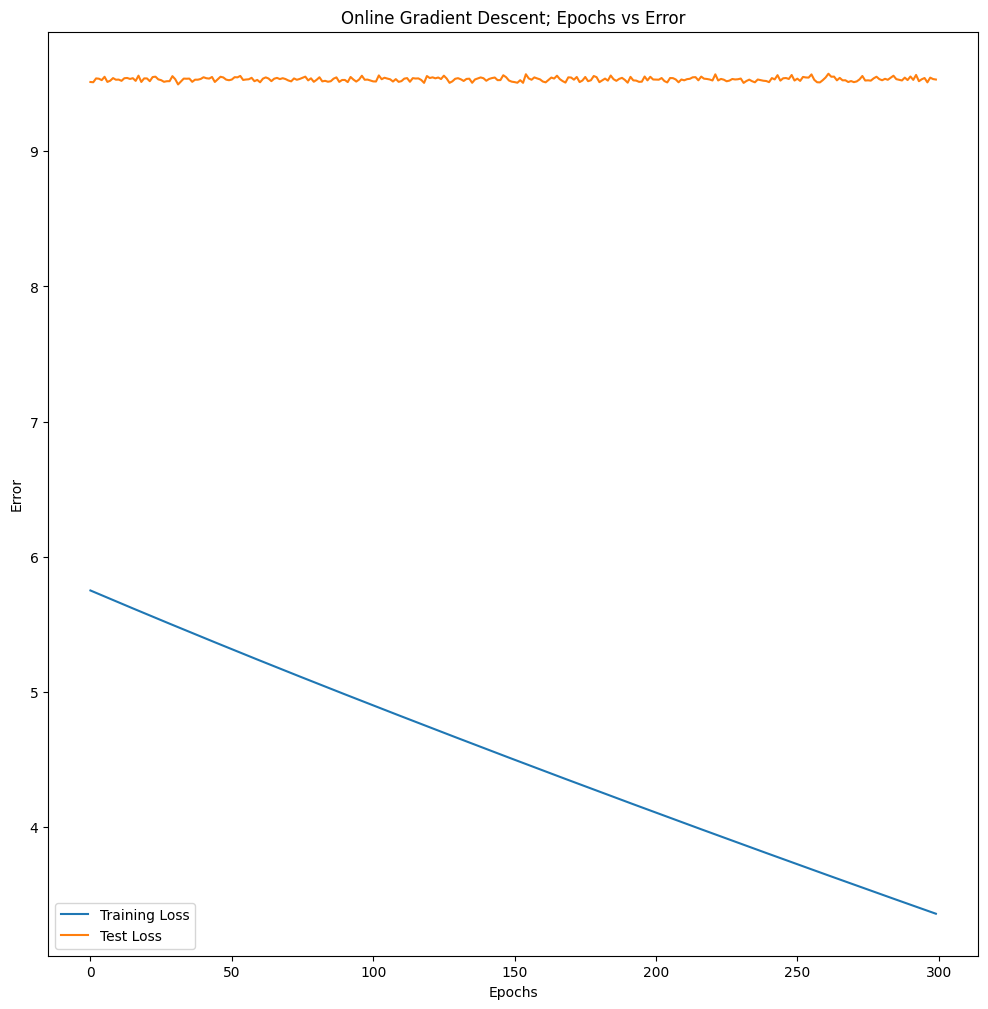

In [27]:
errors = []
test_errors = []

for epoch in epochs:
  
  optimizer.zero_grad()   # zero the gradient buffers
  output = net(x)
  loss = criterion(output, target)
  loss.backward()
  optimizer.step()  
  
  # update_online(w,x, 1/(13+N))
  with torch.no_grad():
    x_test = torch.normal(torch.zeros(1000, Lx), torch.ones(1000, Lx))

    test_target = (wy_dad @ F.relu(wh_dad @ x_test.T)).T
    test_output = net(x_test)
    test_loss = criterion(test_output, test_target)
    test_errors.append(float(torch.log(test_loss)))

  errors.append(float(torch.log(loss)))

plt.figure(figsize = (8,8))
plt.plot(epochs, errors, label = "Training Loss")
plt.plot(epochs, test_errors, label = "Test Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.title("Online Gradient Descent; Epochs vs Error")

  

## Node Perturbation

In [30]:

def update_node_pert(weights, x, eta,sigma):
  final_dad, final_son, hidden_dad, hidden_son = weights


  # Forward 

  y_hat_dad = relu(final_dad @ relu(hidden_dad @ x))

  x_h = relu(hidden_son @ x)
  y_son = final_son @ x_h

  error = np.linalg.norm(y_hat_dad - y_son)
  loss = (1/2) * error**2

  # Forward with perturbations

  xi_h = np.random.normal(scale = sigma, size = (Lh))

  xi_y = np.random.normal(scale = sigma, size = (Ly))

  x_h_xi = relu(hidden_son @ x) + xi_h
  y_son_xi = final_son @ x_h_xi + xi_y

  error_xi = np.linalg.norm(y_hat_dad - y_son_xi)
  loss_xi = (1/2) * error_xi**2

  total_err = (eta/sigma) * (error_xi - error)
  update_h =  total_err * np.outer(xi_h, x)
  update_y =  total_err * np.outer(xi_y, x_h)

  return update_h, update_y, loss


epochs = np.arange(1e3)

wh_son = np.random.normal(size = (Lh,Lx))
wh_dad = np.random.normal(size = (Lh,Lx))

wy_son = np.random.normal(size = (Ly,Lh))
wy_dad = np.random.normal(size = (Ly,Lh))

## The idea is we want the son to converge to the dad.



Text(0.5, 1.0, 'Node Perturbation; Epochs vs Error')

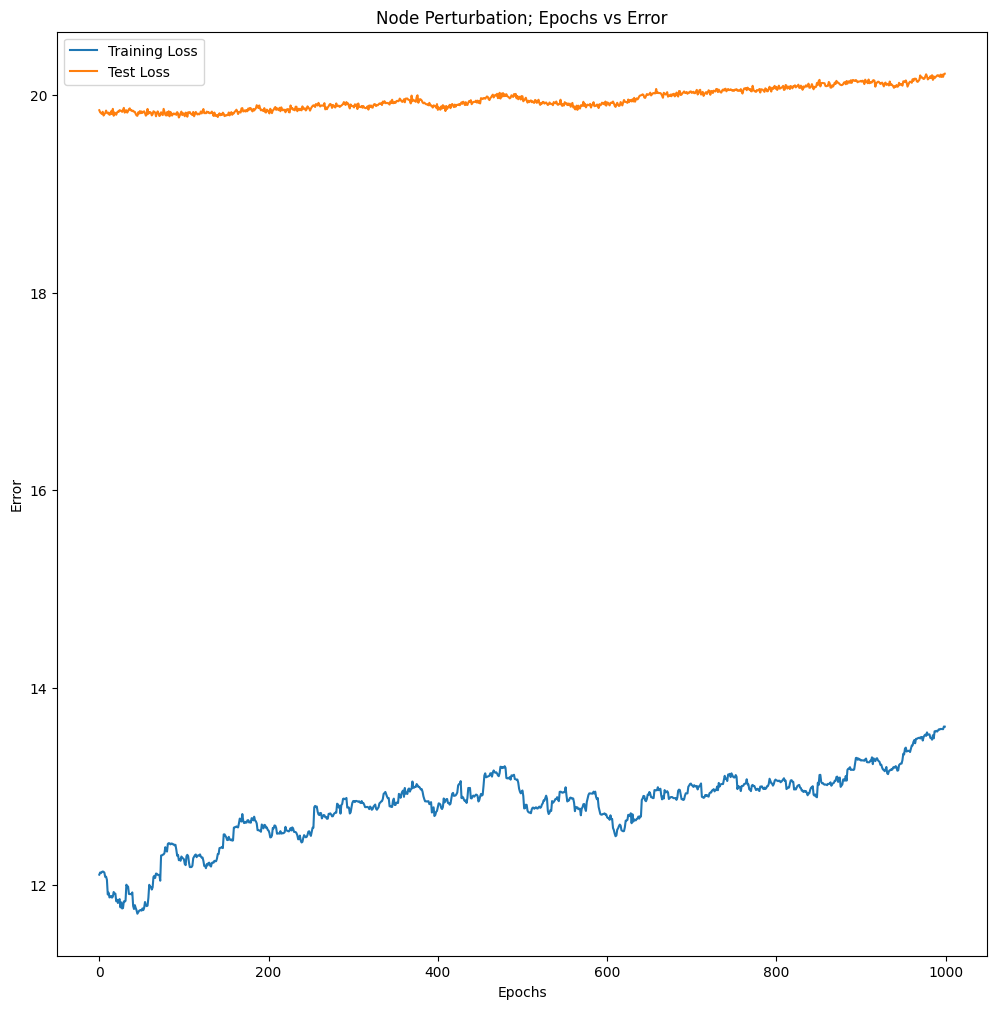

In [38]:
# Node Perturbation

errors = []
test_errors = []
testing = True

x = np.random.normal(size = (Lx))

for epoch in epochs:
  wy = wy_dad - wy_son
  wh = wh_dad - wh_son

  eta = 0.1

  hidden_update, final_update, err = update_node_pert((wy_dad, wy_son, wh_dad, wh_son), x, eta, sigma = 1/(Lh * Ly))
  # update_online(w,x, 1/(13+N))

  wh_son -= hidden_update
  wy_son -= final_update
  
  if testing:
    x_test = np.random.normal(torch.zeros(1000, Lx), torch.ones(1000, Lx))

    test_target = (wy_dad @ relu(wh_dad @ x_test.T)).T
    test_output = (wy_son @ relu(wh_son @ x_test.T)).T
    test_loss = 0.5 * np.linalg.norm(test_output - test_target)**2
    test_errors.append(float(np.log(test_loss)))

  errors.append(np.log(err))

plt.figure(figsize = (8,8))
plt.plot(epochs, errors, label = "Training Loss")
if testing:
    plt.plot(epochs, test_errors, label = "Test Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.title("Node Perturbation; Epochs vs Error")




## Weight Perturbation

In [40]:
# Weight Perturbation

def update_weight_pert(weights, x, eta,sigma):
  final_dad, final_son, hidden_dad, hidden_son = weights


  # Forward 

  y_hat_dad = relu(final_dad @ relu(hidden_dad @ x))

  x_h = relu(hidden_son @ x)
  y_son = final_son @ x_h

  error = np.linalg.norm(y_hat_dad - y_son)
  loss = (1/2) * error**2

  # Forward with perturbations

  xi_h = np.random.normal(scale = sigma, size = (Lh, Lx))

  xi_y = np.random.normal(scale = sigma, size = (Ly, Lh))

  x_h_xi = relu((hidden_son + xi_h) @ x)
  y_son_xi = (final_son + xi_y) @ x_h_xi

  error_xi = np.linalg.norm(y_hat_dad - y_son_xi)
  loss_xi = (1/2) * error_xi**2

  total_err = (eta/sigma) * (error_xi - error)
  update_h =  total_err * xi_h
  update_y =  total_err * xi_y

  return update_h, update_y, loss

Text(0.5, 1.0, 'Node Perturbation; Epochs vs Error')

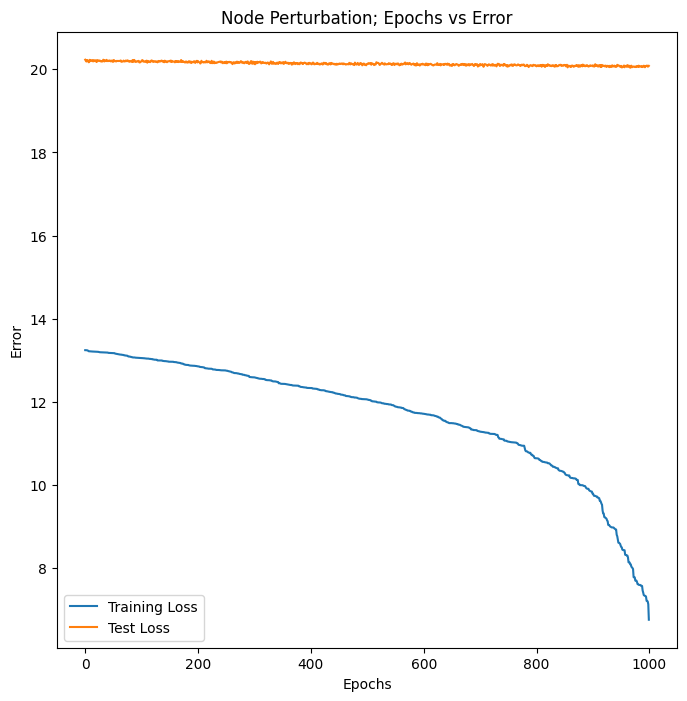

In [41]:
# Weight Perturbation

errors = []
test_errors = []
testing = True

x = np.random.normal(size = (Lx))

for epoch in epochs:
  wy = wy_dad - wy_son
  wh = wh_dad - wh_son

  eta = 0.1

  hidden_update, final_update, err = update_weight_pert((wy_dad, wy_son, wh_dad, wh_son), x, eta, sigma = 1/(Lh * Ly))
  # update_online(w,x, 1/(13+N))

  wh_son -= hidden_update
  wy_son -= final_update
  
  if testing:
    x_test = np.random.normal(torch.zeros(1000,Lx), torch.ones(1000,Lx))

    test_target = (wy_dad @ relu(wh_dad @ x_test.T)).T
    test_output = (wy_son @ relu(wh_son @ x_test.T)).T
    test_loss = 0.5 * np.linalg.norm(test_output - test_target)**2
    test_errors.append(float(np.log(test_loss)))

  errors.append(np.log(err))

plt.figure(figsize = (8,8))
plt.plot(epochs, errors, label = "Training Loss")
if testing:
    plt.plot(epochs, test_errors, label = "Test Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.title("Weight Perturbation; Epochs vs Error")


